In [ ]:
import sys
import site
site.addsitedir(site.USER_SITE)
site.addsitedir(sys.prefix)
#site.main()

site_packages = [p for p in sys.path if 'site-packages' in p]
print(site_packages)



In [ ]:
#!wget -nc http://cs.uef.fi/~vvestman/sounds/Im_Superman.wav
#!wget -nc http://cs.uef.fi/~vvestman/sounds/Count_Of_Three-8khz.wav
  
# Backup links:
!wget -nc https://vvestman.github.io/summerschool19/sounds/Im_Superman.wav  
!wget -nc https://vvestman.github.io/summerschool19/sounds/Count_Of_Three-8khz.wav

In [ ]:

  
#!pip3 install pysoundfile --user
#!pip3 install bitstring --user
#!pip3 install librosa --user
#!pip3 install appdirs --user

%pip install pysoundfile --user
%pip install bitstring --user
%pip install librosa --user
#%pip install appdirs --user

In [2]:
#wavfile = 'Im_Superman.wav'

wavfile = 'Sedge St 3.wav'
import IPython
IPython.display.Audio(wavfile)


In [3]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widgets
#%matplotlib ipympl

Sampling rate: 48000 samples/second
Signal size: 447680 samples
Signal duration: 9.327 seconds


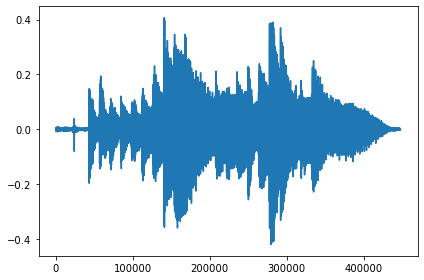

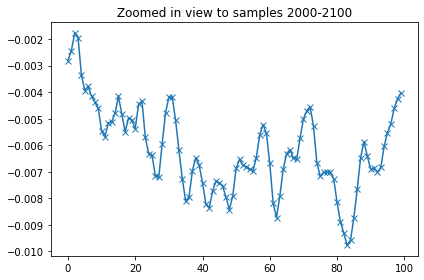

In [4]:
import soundfile
import matplotlib.pyplot as plt
audio_signal, sampling_rate = soundfile.read(wavfile)
print('Sampling rate: {} samples/second'.format(sampling_rate))
print('Signal size: {} samples'.format(audio_signal.shape[0]))
print('Signal duration: {:.3f} seconds'.format(audio_signal.shape[0] / sampling_rate))
plt.plot(audio_signal)
plt.tight_layout()
plt.figure()
plt.plot(audio_signal[2000:2100], marker='x')
plt.title('Zoomed in view to samples 2000-2100')
plt.tight_layout()

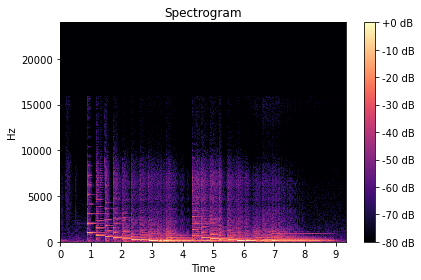

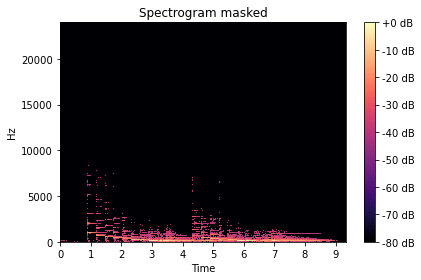

In [10]:
import numpy as np
import librosa
from librosa.display import specshow

def amplitude_to_db(amp,ref=1.0):
    if np.isscalar(amp): 
        return librosa.amplitude_to_db(np.array([amp]), ref=ref)[0]
    else:
        return librosa.amplitude_to_db(amp, ref=ref)

def db_to_amplitude(dB,ref=1.0):
    if np.isscalar(dB): 
        return librosa.db_to_amplitude(np.array([dB]), ref=ref)[0]
    else:
        return librosa.db_to_amplitude(dB, ref=ref)


n_fft=2048
window_length = int(0.025 * sampling_rate)
hop_length = int(0.01 * sampling_rate)
dt = hop_length / sampling_rate
spectrogram = np.abs(librosa.stft(audio_signal, hop_length=hop_length, win_length=window_length,n_fft=n_fft))

nf, nt = np.shape(spectrogram)
t = np.arange(nt) * dt
f = librosa.fft_frequencies(sr=sampling_rate, n_fft=n_fft)

thresh = .7
mask = (spectrogram > thresh).astype(int)
specmin=np.min(spectrogram)
spectrogram_masked = spectrogram * mask + specmin * (1-mask) 
# Plotting the spectrogram:
specshow(amplitude_to_db(spectrogram, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#plt.ylim(0,2500)
plt.figure()
specshow(librosa.amplitude_to_db(spectrogram_masked, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
plt.title('Spectrogram masked')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#plt.ylim(0,2500)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border, quickshift
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

specmax = np.amax(spectrogram)
specmin = np.amin(spectrogram)
levels = librosa.amplitude_to_db(spectrogram, ref=specmax)
levoff = np.min(levels)
levels = levels - levoff
levscale = np.max(levels)/255
levels = levels/levscale
levels = np.uint8(levels)

def db_to_level(dB):
    return (dB-levoff)/levscale
def level_to_db(level):
    return level*levcale+levoff

# apply threshold
#thresh = threshold_otsu(image)
threshdB = -40.0 # dB
thresh_level = db_to_level(threshdB)
bw = closing(levels > thresh_level, square(3))

# remove artifacts connected to image border
#cleared = clear_border(bw)
cleared = bw

# label image regions
label_levels = label(cleared)
#label_levels= quickshift(np.repeat(levels[:,:,np.newaxis],3, axis=2)) 
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
levels_label_overlay = label2rgb(label_levels, image=levels, bg_label=0)

image = np.flip(levels,axis=0)
label_image = np.flip(label_levels,axis=0)
image_label_overlay = np.flip(levels_label_overlay,axis=0)
fimg = np.flip(f)
timg = t

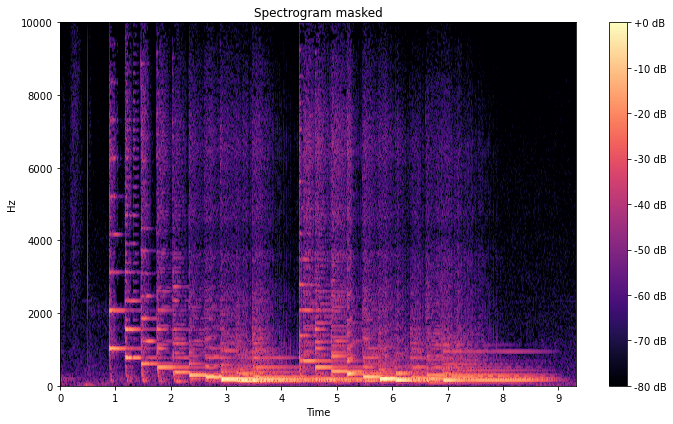

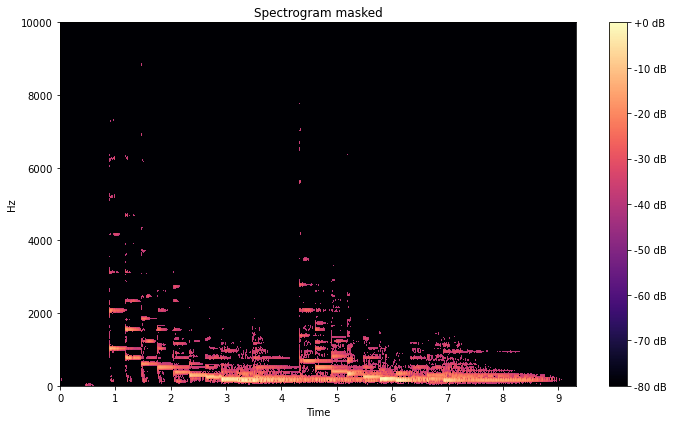

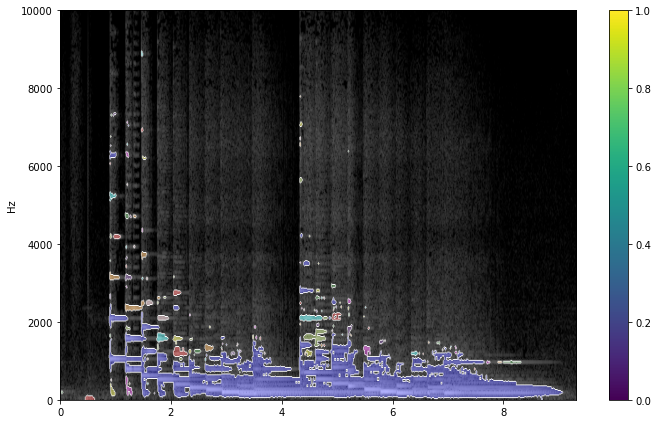

In [21]:
import numpy.ma as ma
from skimage.segmentation import mark_boundaries

def drawboxes(ax,label_levels, spectrogram , t,f, mindt=0, mythresh=0.0):
    for region in regionprops(label_levels):
        mask = label_levels == region.label #true means in region - valid
        specma = ma.masked_array(spectrogram, mask = ~mask) #true means invalid to masked_array
        minr, minc, maxr, maxc = region.bbox
        if maxr > len(f)-1: maxr = len(f)-1
        if maxc > len(t)-1: maxc = len(t)-1
        minf, mint, maxf, maxt = f[minr], t[minc], f[maxr], t[maxc]
        mytime = maxt - mint
        specmax=np.max(spectrogram)
        mylevel = specma.mean()
        if mylevel >= mythresh and mytime >= mindt:
            rect = mpatches.Rectangle((mint, minf), maxt - mint, maxf - minf,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

def clean_labels(label_levels, spectrogram , t,f, mindt=0, mythresh=0.0):
    label_levels_clean = label_levels
    for region in regionprops(label_levels):
        mask = label_levels == region.label #true means in region - valid
        specma = ma.masked_array(spectrogram, mask = ~mask) #true means invalid to masked_array
        minr, minc, maxr, maxc = region.bbox
        if maxr > len(f)-1: maxr = len(f)-1
        if maxc > len(t)-1: maxc = len(t)-1
        minf, mint, maxf, maxt = f[minr], t[minc], f[maxr], t[maxc]
        mytime = maxt - mint
        specmax=np.max(spectrogram)
        mylevel = specma.mean()
        if not (mylevel >= mythresh and mytime >= mindt):
            label_levels_clean=label_levels * (~mask)
    return label_levels_clean


label_levels_clean = clean_labels(label_levels, spectrogram , t,f, mindt=0, mythresh=db_to_amplitude(threshdB,ref=specmax))

ylimits=(0,10000)

specshowmax=specmax
fig, ax = plt.subplots(figsize=(10, 6))
specshow(librosa.amplitude_to_db(spectrogram, ref=specshowmax), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time') 
plt.title('Spectrogram masked')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.ylim(*ylimit)

mask = (librosa.amplitude_to_db(spectrogram, ref=specshowmax) > threshdB).astype(int)
specmin=np.min(spectrogram)
spectrogram_masked = spectrogram * mask + specmin * (1-mask) 
fig, ax = plt.subplots(figsize=(10, 6))
specshow(librosa.amplitude_to_db(spectrogram_masked, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
plt.title('Spectrogram masked')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.ylim(*ylimits)



extent = np.min(t), np.max(t), np.min(f), np.max(f)
fig, ax = plt.subplots(figsize=(10, 6))
image_label_overlay_with_boundaries=mark_boundaries(image_label_overlay, label_image, color=(1, 1, 1), outline_color=None, mode='outer', background_label=0)


plt.imshow(image_label_overlay_with_boundaries,extent=extent,aspect='auto')
plt.ylabel('Hz')
plt.colorbar()
#drawboxes(ax,label_levels, spectrogram , t,f, mindt=0, mythresh=threshdB)
plt.tight_layout()
plt.ylim(*ylimits)

plt.show()

In [ ]:
print(thresh)

In [ ]:
print(threshdB)

In [25]:
v=(1,2,3)
u,*_= v
print(u)

1
